<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:09:20] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


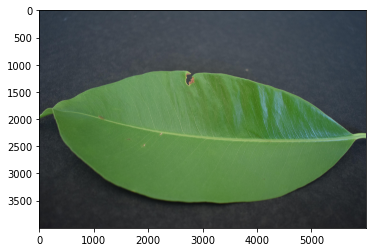

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

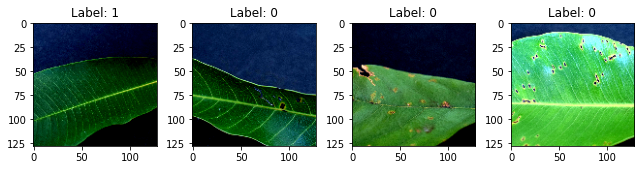

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:09:26] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:09:28] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2615302735922185 samples/sec                   batch loss = 0.966609001159668 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2561595913853882 samples/sec                   batch loss = 1.1678301095962524 | accuracy = 0.45


Epoch[1] Batch[15] Speed: 1.22862086611786 samples/sec                   batch loss = 0.5679498910903931 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.2676127487998936 samples/sec                   batch loss = 0.587593674659729 | accuracy = 0.5125


Epoch[1] Batch[25] Speed: 1.2741448750219482 samples/sec                   batch loss = 1.4514241218566895 | accuracy = 0.51


Epoch[1] Batch[30] Speed: 1.2736271998386977 samples/sec                   batch loss = 0.4613390862941742 | accuracy = 0.525


Epoch[1] Batch[35] Speed: 1.2724383927270582 samples/sec                   batch loss = 0.6187404990196228 | accuracy = 0.55


Epoch[1] Batch[40] Speed: 1.2683704005154763 samples/sec                   batch loss = 0.5451952219009399 | accuracy = 0.575


Epoch[1] Batch[45] Speed: 1.2726827924684425 samples/sec                   batch loss = 0.49999648332595825 | accuracy = 0.6055555555555555


Epoch[1] Batch[50] Speed: 1.2722868001014964 samples/sec                   batch loss = 0.3933574855327606 | accuracy = 0.61


Epoch[1] Batch[55] Speed: 1.267804711469514 samples/sec                   batch loss = 1.7934837341308594 | accuracy = 0.6045454545454545


Epoch[1] Batch[60] Speed: 1.2723545346717267 samples/sec                   batch loss = 0.5177227258682251 | accuracy = 0.5916666666666667


Epoch[1] Batch[65] Speed: 1.2698266224954038 samples/sec                   batch loss = 0.8705018758773804 | accuracy = 0.5884615384615385


Epoch[1] Batch[70] Speed: 1.2741459394364318 samples/sec                   batch loss = 0.9559393525123596 | accuracy = 0.6


Epoch[1] Batch[75] Speed: 1.2739886189182863 samples/sec                   batch loss = 1.1738183498382568 | accuracy = 0.6066666666666667


Epoch[1] Batch[80] Speed: 1.2749918399900901 samples/sec                   batch loss = 0.38554999232292175 | accuracy = 0.60625


Epoch[1] Batch[85] Speed: 1.2666056108766177 samples/sec                   batch loss = 0.3106033504009247 | accuracy = 0.611764705882353


Epoch[1] Batch[90] Speed: 1.2685169370197804 samples/sec                   batch loss = 0.9398760199546814 | accuracy = 0.6083333333333333


Epoch[1] Batch[95] Speed: 1.2657186585893676 samples/sec                   batch loss = 0.6590076088905334 | accuracy = 0.6105263157894737


Epoch[1] Batch[100] Speed: 1.2675968503075565 samples/sec                   batch loss = 1.1112638711929321 | accuracy = 0.6125


Epoch[1] Batch[105] Speed: 1.2694885011640296 samples/sec                   batch loss = 0.623228132724762 | accuracy = 0.611904761904762


Epoch[1] Batch[110] Speed: 1.2594254700639764 samples/sec                   batch loss = 0.5078659057617188 | accuracy = 0.6136363636363636


Epoch[1] Batch[115] Speed: 1.2612183616956594 samples/sec                   batch loss = 0.6409727334976196 | accuracy = 0.6239130434782608


Epoch[1] Batch[120] Speed: 1.2643420566059533 samples/sec                   batch loss = 0.3427591919898987 | accuracy = 0.6354166666666666


Epoch[1] Batch[125] Speed: 1.2616309263065724 samples/sec                   batch loss = 0.4210333824157715 | accuracy = 0.642


Epoch[1] Batch[130] Speed: 1.2655781140254831 samples/sec                   batch loss = 0.41223323345184326 | accuracy = 0.65


Epoch[1] Batch[135] Speed: 1.2640120871059393 samples/sec                   batch loss = 0.207285538315773 | accuracy = 0.6611111111111111


Epoch[1] Batch[140] Speed: 1.2639023894506454 samples/sec                   batch loss = 0.8315503597259521 | accuracy = 0.6642857142857143


Epoch[1] Batch[145] Speed: 1.2672287106504756 samples/sec                   batch loss = 0.5441831946372986 | accuracy = 0.6655172413793103


Epoch[1] Batch[150] Speed: 1.2569864794589836 samples/sec                   batch loss = 0.7225701808929443 | accuracy = 0.6633333333333333


Epoch[1] Batch[155] Speed: 1.2620740460901974 samples/sec                   batch loss = 0.401434063911438 | accuracy = 0.6612903225806451


Epoch[1] Batch[160] Speed: 1.258713498378706 samples/sec                   batch loss = 0.49282100796699524 | accuracy = 0.6609375


Epoch[1] Batch[165] Speed: 1.2646385473329187 samples/sec                   batch loss = 0.6619271636009216 | accuracy = 0.6621212121212121


Epoch[1] Batch[170] Speed: 1.2598108468339935 samples/sec                   batch loss = 0.584917426109314 | accuracy = 0.6602941176470588


Epoch[1] Batch[175] Speed: 1.261807510534795 samples/sec                   batch loss = 0.7929487228393555 | accuracy = 0.6628571428571428


Epoch[1] Batch[180] Speed: 1.2636232795621867 samples/sec                   batch loss = 0.6674190163612366 | accuracy = 0.6638888888888889


Epoch[1] Batch[185] Speed: 1.2650960886058062 samples/sec                   batch loss = 0.8535484075546265 | accuracy = 0.6621621621621622


Epoch[1] Batch[190] Speed: 1.2615201238329568 samples/sec                   batch loss = 0.601460874080658 | accuracy = 0.6631578947368421


Epoch[1] Batch[195] Speed: 1.2643455820368625 samples/sec                   batch loss = 0.7936370372772217 | accuracy = 0.6628205128205128


Epoch[1] Batch[200] Speed: 1.2610634588547733 samples/sec                   batch loss = 1.0575929880142212 | accuracy = 0.65875


Epoch[1] Batch[205] Speed: 1.2699037074625203 samples/sec                   batch loss = 0.36252284049987793 | accuracy = 0.6585365853658537


Epoch[1] Batch[210] Speed: 1.2695759207901371 samples/sec                   batch loss = 1.2005412578582764 | accuracy = 0.6571428571428571


Epoch[1] Batch[215] Speed: 1.2665706137809594 samples/sec                   batch loss = 0.3559176027774811 | accuracy = 0.6558139534883721


Epoch[1] Batch[220] Speed: 1.2758157735703681 samples/sec                   batch loss = 0.3759128451347351 | accuracy = 0.6590909090909091


Epoch[1] Batch[225] Speed: 1.263446757666998 samples/sec                   batch loss = 0.3368193209171295 | accuracy = 0.6622222222222223


Epoch[1] Batch[230] Speed: 1.2716601632967386 samples/sec                   batch loss = 1.2800891399383545 | accuracy = 0.6565217391304348


Epoch[1] Batch[235] Speed: 1.2704852218731468 samples/sec                   batch loss = 0.5135002136230469 | accuracy = 0.6563829787234042


Epoch[1] Batch[240] Speed: 1.258005444063381 samples/sec                   batch loss = 0.6904042363166809 | accuracy = 0.653125


Epoch[1] Batch[245] Speed: 1.2682849684803832 samples/sec                   batch loss = 0.46511781215667725 | accuracy = 0.6530612244897959


Epoch[1] Batch[250] Speed: 1.2657628716550928 samples/sec                   batch loss = 0.6058693528175354 | accuracy = 0.652


Epoch[1] Batch[255] Speed: 1.263856782922115 samples/sec                   batch loss = 0.6637524962425232 | accuracy = 0.6519607843137255


Epoch[1] Batch[260] Speed: 1.2621475340217618 samples/sec                   batch loss = 0.9237484931945801 | accuracy = 0.6509615384615385


Epoch[1] Batch[265] Speed: 1.2655341047885258 samples/sec                   batch loss = 0.661136269569397 | accuracy = 0.6518867924528302


Epoch[1] Batch[270] Speed: 1.265862386225132 samples/sec                   batch loss = 0.45076093077659607 | accuracy = 0.6518518518518519


Epoch[1] Batch[275] Speed: 1.2657826396188865 samples/sec                   batch loss = 1.1152158975601196 | accuracy = 0.6527272727272727


Epoch[1] Batch[280] Speed: 1.2641418062972696 samples/sec                   batch loss = 0.4554506540298462 | accuracy = 0.6535714285714286


Epoch[1] Batch[285] Speed: 1.2626958302974307 samples/sec                   batch loss = 0.48465245962142944 | accuracy = 0.6517543859649123


Epoch[1] Batch[290] Speed: 1.2634015645735828 samples/sec                   batch loss = 0.5899280905723572 | accuracy = 0.653448275862069


Epoch[1] Batch[295] Speed: 1.2653530404170898 samples/sec                   batch loss = 0.5839673280715942 | accuracy = 0.6542372881355932


Epoch[1] Batch[300] Speed: 1.2689708587472166 samples/sec                   batch loss = 0.4226711392402649 | accuracy = 0.6516666666666666


Epoch[1] Batch[305] Speed: 1.2679057930237891 samples/sec                   batch loss = 0.2646656334400177 | accuracy = 0.6532786885245901


Epoch[1] Batch[310] Speed: 1.2656206942047963 samples/sec                   batch loss = 0.7509985566139221 | accuracy = 0.6564516129032258


Epoch[1] Batch[315] Speed: 1.256459784218523 samples/sec                   batch loss = 0.7831934094429016 | accuracy = 0.6555555555555556


Epoch[1] Batch[320] Speed: 1.2595736348963698 samples/sec                   batch loss = 0.3636920154094696 | accuracy = 0.6578125


Epoch[1] Batch[325] Speed: 1.2597744269158901 samples/sec                   batch loss = 0.6577271819114685 | accuracy = 0.6576923076923077


Epoch[1] Batch[330] Speed: 1.259162792484958 samples/sec                   batch loss = 1.1970213651657104 | accuracy = 0.6583333333333333


Epoch[1] Batch[335] Speed: 1.2640702764900573 samples/sec                   batch loss = 0.5082796216011047 | accuracy = 0.6597014925373135


Epoch[1] Batch[340] Speed: 1.2557626277667944 samples/sec                   batch loss = 0.9771586656570435 | accuracy = 0.6580882352941176


Epoch[1] Batch[345] Speed: 1.26524549534059 samples/sec                   batch loss = 0.43977248668670654 | accuracy = 0.6601449275362319


Epoch[1] Batch[350] Speed: 1.2664996693192838 samples/sec                   batch loss = 0.6777488589286804 | accuracy = 0.6585714285714286


Epoch[1] Batch[355] Speed: 1.266992524560927 samples/sec                   batch loss = 0.34681257605552673 | accuracy = 0.6577464788732394


Epoch[1] Batch[360] Speed: 1.2704010438704867 samples/sec                   batch loss = 1.6580709218978882 | accuracy = 0.6555555555555556


Epoch[1] Batch[365] Speed: 1.2679268736728202 samples/sec                   batch loss = 0.5699476003646851 | accuracy = 0.6582191780821918


Epoch[1] Batch[370] Speed: 1.268298295503726 samples/sec                   batch loss = 0.18346887826919556 | accuracy = 0.6601351351351351


Epoch[1] Batch[375] Speed: 1.2646300633452634 samples/sec                   batch loss = 1.2057043313980103 | accuracy = 0.66


Epoch[1] Batch[380] Speed: 1.266786364368432 samples/sec                   batch loss = 0.8774257898330688 | accuracy = 0.6585526315789474


Epoch[1] Batch[385] Speed: 1.2633002486509133 samples/sec                   batch loss = 0.569305419921875 | accuracy = 0.6597402597402597


Epoch[1] Batch[390] Speed: 1.2663227252526423 samples/sec                   batch loss = 0.6998564600944519 | accuracy = 0.6576923076923077


Epoch[1] Batch[395] Speed: 1.2607484617894507 samples/sec                   batch loss = 0.5466299057006836 | accuracy = 0.6594936708860759


Epoch[1] Batch[400] Speed: 1.2683658937120494 samples/sec                   batch loss = 0.7005939483642578 | accuracy = 0.65875


Epoch[1] Batch[405] Speed: 1.2677285516571009 samples/sec                   batch loss = 0.8797948360443115 | accuracy = 0.658641975308642


Epoch[1] Batch[410] Speed: 1.2690483198090696 samples/sec                   batch loss = 0.7674865126609802 | accuracy = 0.6609756097560976


Epoch[1] Batch[415] Speed: 1.2693031345414494 samples/sec                   batch loss = 0.3088776469230652 | accuracy = 0.6626506024096386


Epoch[1] Batch[420] Speed: 1.267907613597641 samples/sec                   batch loss = 0.4012813866138458 | accuracy = 0.6636904761904762


Epoch[1] Batch[425] Speed: 1.263913148881884 samples/sec                   batch loss = 0.4975782036781311 | accuracy = 0.6641176470588235


Epoch[1] Batch[430] Speed: 1.2647134782783716 samples/sec                   batch loss = 0.5515797138214111 | accuracy = 0.6656976744186046


Epoch[1] Batch[435] Speed: 1.2689499353242464 samples/sec                   batch loss = 0.46089497208595276 | accuracy = 0.6672413793103448


Epoch[1] Batch[440] Speed: 1.2632699046027775 samples/sec                   batch loss = 0.48430898785591125 | accuracy = 0.6670454545454545


Epoch[1] Batch[445] Speed: 1.269930429872388 samples/sec                   batch loss = 0.2762664556503296 | accuracy = 0.6674157303370787


Epoch[1] Batch[450] Speed: 1.2631874408394377 samples/sec                   batch loss = 2.005131244659424 | accuracy = 0.6672222222222223


Epoch[1] Batch[455] Speed: 1.2679571543771053 samples/sec                   batch loss = 0.8550586104393005 | accuracy = 0.667032967032967


Epoch[1] Batch[460] Speed: 1.2685544396943471 samples/sec                   batch loss = 0.36549752950668335 | accuracy = 0.6673913043478261


Epoch[1] Batch[465] Speed: 1.2594786049417739 samples/sec                   batch loss = 0.6058114767074585 | accuracy = 0.667741935483871


Epoch[1] Batch[470] Speed: 1.2618753677006485 samples/sec                   batch loss = 0.22430969774723053 | accuracy = 0.6686170212765957


Epoch[1] Batch[475] Speed: 1.270052617518476 samples/sec                   batch loss = 1.299965262413025 | accuracy = 0.6689473684210526


Epoch[1] Batch[480] Speed: 1.273055074307762 samples/sec                   batch loss = 1.358401894569397 | accuracy = 0.6692708333333334


Epoch[1] Batch[485] Speed: 1.2759834441435305 samples/sec                   batch loss = 0.3997046649456024 | accuracy = 0.6711340206185566


Epoch[1] Batch[490] Speed: 1.2689180716203021 samples/sec                   batch loss = 0.4825553297996521 | accuracy = 0.6714285714285714


Epoch[1] Batch[495] Speed: 1.2721570438960186 samples/sec                   batch loss = 0.33132004737854004 | accuracy = 0.6717171717171717


Epoch[1] Batch[500] Speed: 1.2784811014014417 samples/sec                   batch loss = 0.4010508060455322 | accuracy = 0.671


Epoch[1] Batch[505] Speed: 1.2752867552948006 samples/sec                   batch loss = 0.34778258204460144 | accuracy = 0.6722772277227723


Epoch[1] Batch[510] Speed: 1.2743062024880438 samples/sec                   batch loss = 0.5001925826072693 | accuracy = 0.6725490196078432


Epoch[1] Batch[515] Speed: 1.2799369171715933 samples/sec                   batch loss = 0.7844730019569397 | accuracy = 0.6733009708737864


Epoch[1] Batch[520] Speed: 1.2824743049792722 samples/sec                   batch loss = 0.7036889791488647 | accuracy = 0.6735576923076924


Epoch[1] Batch[525] Speed: 1.2741382950446174 samples/sec                   batch loss = 0.6413025259971619 | accuracy = 0.6752380952380952


Epoch[1] Batch[530] Speed: 1.2710131519417303 samples/sec                   batch loss = 0.5805219411849976 | accuracy = 0.6754716981132075


Epoch[1] Batch[535] Speed: 1.2725896353660826 samples/sec                   batch loss = 0.599899411201477 | accuracy = 0.6757009345794392


Epoch[1] Batch[540] Speed: 1.2639611400802289 samples/sec                   batch loss = 0.9021598100662231 | accuracy = 0.674074074074074


Epoch[1] Batch[545] Speed: 1.2641862902996106 samples/sec                   batch loss = 0.4120287299156189 | accuracy = 0.6743119266055045


Epoch[1] Batch[550] Speed: 1.2723166140023705 samples/sec                   batch loss = 0.3323807418346405 | accuracy = 0.6754545454545454


Epoch[1] Batch[555] Speed: 1.2652088559407415 samples/sec                   batch loss = 0.38268470764160156 | accuracy = 0.6752252252252252


Epoch[1] Batch[560] Speed: 1.2651042926576788 samples/sec                   batch loss = 0.5442909598350525 | accuracy = 0.6767857142857143


Epoch[1] Batch[565] Speed: 1.2683489215695392 samples/sec                   batch loss = 0.6761090159416199 | accuracy = 0.6774336283185841


Epoch[1] Batch[570] Speed: 1.2693403956081404 samples/sec                   batch loss = 0.5347245335578918 | accuracy = 0.6789473684210526


Epoch[1] Batch[575] Speed: 1.2666868001111367 samples/sec                   batch loss = 0.7137030959129333 | accuracy = 0.6778260869565217


Epoch[1] Batch[580] Speed: 1.2687065832599433 samples/sec                   batch loss = 1.1765462160110474 | accuracy = 0.678448275862069


Epoch[1] Batch[585] Speed: 1.2681893864565588 samples/sec                   batch loss = 0.6463384628295898 | accuracy = 0.6790598290598291


Epoch[1] Batch[590] Speed: 1.267266807252386 samples/sec                   batch loss = 0.4643138349056244 | accuracy = 0.6805084745762712


Epoch[1] Batch[595] Speed: 1.2663479589846522 samples/sec                   batch loss = 0.6322909593582153 | accuracy = 0.680672268907563


Epoch[1] Batch[600] Speed: 1.2669377970774944 samples/sec                   batch loss = 0.31177935004234314 | accuracy = 0.6791666666666667


Epoch[1] Batch[605] Speed: 1.2704449112434102 samples/sec                   batch loss = 0.4498436748981476 | accuracy = 0.6805785123966942


Epoch[1] Batch[610] Speed: 1.26326143896855 samples/sec                   batch loss = 0.30283987522125244 | accuracy = 0.6786885245901639


Epoch[1] Batch[615] Speed: 1.2683964830707122 samples/sec                   batch loss = 0.4901753067970276 | accuracy = 0.6780487804878049


Epoch[1] Batch[620] Speed: 1.271523692765876 samples/sec                   batch loss = 0.2532748878002167 | accuracy = 0.6790322580645162


Epoch[1] Batch[625] Speed: 1.263967139236276 samples/sec                   batch loss = 0.3767392635345459 | accuracy = 0.6796


Epoch[1] Batch[630] Speed: 1.2697211984857386 samples/sec                   batch loss = 0.19415512681007385 | accuracy = 0.6805555555555556


Epoch[1] Batch[635] Speed: 1.2720286643651106 samples/sec                   batch loss = 0.7343617677688599 | accuracy = 0.6807086614173228


Epoch[1] Batch[640] Speed: 1.2664034002610522 samples/sec                   batch loss = 0.4699981212615967 | accuracy = 0.681640625


Epoch[1] Batch[645] Speed: 1.2625037964175063 samples/sec                   batch loss = 0.6950886845588684 | accuracy = 0.6810077519379845


Epoch[1] Batch[650] Speed: 1.2689029081304037 samples/sec                   batch loss = 0.375544011592865 | accuracy = 0.6823076923076923


Epoch[1] Batch[655] Speed: 1.260008686340133 samples/sec                   batch loss = 0.4279729723930359 | accuracy = 0.6824427480916031


Epoch[1] Batch[660] Speed: 1.2682246648039266 samples/sec                   batch loss = 0.2339395433664322 | accuracy = 0.6837121212121212


Epoch[1] Batch[665] Speed: 1.2662663353197943 samples/sec                   batch loss = 0.5896671414375305 | accuracy = 0.6845864661654135


Epoch[1] Batch[670] Speed: 1.26394409516984 samples/sec                   batch loss = 0.4148717224597931 | accuracy = 0.6861940298507463


Epoch[1] Batch[675] Speed: 1.261168018838572 samples/sec                   batch loss = 0.43246540427207947 | accuracy = 0.6877777777777778


Epoch[1] Batch[680] Speed: 1.2593684637839209 samples/sec                   batch loss = 0.42017924785614014 | accuracy = 0.6886029411764706


Epoch[1] Batch[685] Speed: 1.2635771221751955 samples/sec                   batch loss = 0.4985688030719757 | accuracy = 0.6897810218978102


Epoch[1] Batch[690] Speed: 1.2613762424794501 samples/sec                   batch loss = 0.2072335183620453 | accuracy = 0.6909420289855073


Epoch[1] Batch[695] Speed: 1.2682619584518589 samples/sec                   batch loss = 0.7633037567138672 | accuracy = 0.6920863309352518


Epoch[1] Batch[700] Speed: 1.2648545937295925 samples/sec                   batch loss = 0.554807722568512 | accuracy = 0.6921428571428572


Epoch[1] Batch[705] Speed: 1.2649674133902056 samples/sec                   batch loss = 0.5388126969337463 | accuracy = 0.6925531914893617


Epoch[1] Batch[710] Speed: 1.2571968101767412 samples/sec                   batch loss = 0.3960135579109192 | accuracy = 0.6936619718309859


Epoch[1] Batch[715] Speed: 1.2638359325993984 samples/sec                   batch loss = 0.5076557397842407 | accuracy = 0.6937062937062937


Epoch[1] Batch[720] Speed: 1.2659554207125359 samples/sec                   batch loss = 0.6073038578033447 | accuracy = 0.6934027777777778


Epoch[1] Batch[725] Speed: 1.2672596280693373 samples/sec                   batch loss = 0.3480990529060364 | accuracy = 0.6931034482758621


Epoch[1] Batch[730] Speed: 1.2662976836794844 samples/sec                   batch loss = 0.17820730805397034 | accuracy = 0.6948630136986301


Epoch[1] Batch[735] Speed: 1.2650937991219486 samples/sec                   batch loss = 0.997151792049408 | accuracy = 0.6938775510204082


Epoch[1] Batch[740] Speed: 1.2621352854388612 samples/sec                   batch loss = 0.39159095287323 | accuracy = 0.6949324324324324


Epoch[1] Batch[745] Speed: 1.2676720364533567 samples/sec                   batch loss = 0.4124060273170471 | accuracy = 0.6949664429530201


Epoch[1] Batch[750] Speed: 1.2717541483840622 samples/sec                   batch loss = 0.6793787479400635 | accuracy = 0.695


Epoch[1] Batch[755] Speed: 1.269975706738021 samples/sec                   batch loss = 0.2675771713256836 | accuracy = 0.695364238410596


Epoch[1] Batch[760] Speed: 1.2701617506732672 samples/sec                   batch loss = 0.5420730710029602 | accuracy = 0.6947368421052632


Epoch[1] Batch[765] Speed: 1.2734583113433031 samples/sec                   batch loss = 0.9374073147773743 | accuracy = 0.6944444444444444


Epoch[1] Batch[770] Speed: 1.2736373519767694 samples/sec                   batch loss = 0.39572206139564514 | accuracy = 0.6951298701298702


Epoch[1] Batch[775] Speed: 1.2702889841839435 samples/sec                   batch loss = 0.6067430973052979 | accuracy = 0.6964516129032258


Epoch[1] Batch[780] Speed: 1.2668142949057686 samples/sec                   batch loss = 0.4091745615005493 | accuracy = 0.6971153846153846


Epoch[1] Batch[785] Speed: 1.2665179305437435 samples/sec                   batch loss = 0.4098757803440094 | accuracy = 0.6968152866242038


[Epoch 1] training: accuracy=0.6963832487309645
[Epoch 1] time cost: 649.1800711154938
[Epoch 1] validation: validation accuracy=0.74


Epoch[2] Batch[5] Speed: 1.2580816664984447 samples/sec                   batch loss = 0.37930595874786377 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2603363793511826 samples/sec                   batch loss = 0.3505769968032837 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.2568872255468835 samples/sec                   batch loss = 0.618491530418396 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.2591183778183077 samples/sec                   batch loss = 0.4508495330810547 | accuracy = 0.8


Epoch[2] Batch[25] Speed: 1.2577090379290685 samples/sec                   batch loss = 0.3277270793914795 | accuracy = 0.82


Epoch[2] Batch[30] Speed: 1.2619532938121458 samples/sec                   batch loss = 0.6029741168022156 | accuracy = 0.8083333333333333


Epoch[2] Batch[35] Speed: 1.2651845262617238 samples/sec                   batch loss = 0.7687515020370483 | accuracy = 0.7928571428571428


Epoch[2] Batch[40] Speed: 1.2706588080772476 samples/sec                   batch loss = 0.44937393069267273 | accuracy = 0.79375


Epoch[2] Batch[45] Speed: 1.2607413562703096 samples/sec                   batch loss = 0.49589622020721436 | accuracy = 0.7833333333333333


Epoch[2] Batch[50] Speed: 1.26432547781611 samples/sec                   batch loss = 0.276082843542099 | accuracy = 0.775


Epoch[2] Batch[55] Speed: 1.2599451930521792 samples/sec                   batch loss = 0.40404316782951355 | accuracy = 0.7727272727272727


Epoch[2] Batch[60] Speed: 1.2657154119632972 samples/sec                   batch loss = 0.31176379323005676 | accuracy = 0.7791666666666667


Epoch[2] Batch[65] Speed: 1.2629731044468397 samples/sec                   batch loss = 0.6474082469940186 | accuracy = 0.7807692307692308


Epoch[2] Batch[70] Speed: 1.260458148136823 samples/sec                   batch loss = 0.3346765637397766 | accuracy = 0.7857142857142857


Epoch[2] Batch[75] Speed: 1.2627598862544744 samples/sec                   batch loss = 0.19936467707157135 | accuracy = 0.7766666666666666


Epoch[2] Batch[80] Speed: 1.2600556243894419 samples/sec                   batch loss = 0.4156687259674072 | accuracy = 0.775


Epoch[2] Batch[85] Speed: 1.260372168978897 samples/sec                   batch loss = 0.5239861607551575 | accuracy = 0.7676470588235295


Epoch[2] Batch[90] Speed: 1.2652774611335855 samples/sec                   batch loss = 0.7823404669761658 | accuracy = 0.7694444444444445


Epoch[2] Batch[95] Speed: 1.2531911818366182 samples/sec                   batch loss = 0.6606506705284119 | accuracy = 0.7684210526315789


Epoch[2] Batch[100] Speed: 1.2582044153504512 samples/sec                   batch loss = 0.5856417417526245 | accuracy = 0.7675


Epoch[2] Batch[105] Speed: 1.25540921982451 samples/sec                   batch loss = 0.5660619139671326 | accuracy = 0.7666666666666667


Epoch[2] Batch[110] Speed: 1.253650967649616 samples/sec                   batch loss = 0.08730801194906235 | accuracy = 0.775


Epoch[2] Batch[115] Speed: 1.2563392571047178 samples/sec                   batch loss = 0.19413675367832184 | accuracy = 0.7739130434782608


Epoch[2] Batch[120] Speed: 1.2541003102880948 samples/sec                   batch loss = 0.44217371940612793 | accuracy = 0.7666666666666667


Epoch[2] Batch[125] Speed: 1.2601259433735519 samples/sec                   batch loss = 0.3608122169971466 | accuracy = 0.772


Epoch[2] Batch[130] Speed: 1.2600841106768765 samples/sec                   batch loss = 0.30757832527160645 | accuracy = 0.7692307692307693


Epoch[2] Batch[135] Speed: 1.261974936388692 samples/sec                   batch loss = 0.8551809191703796 | accuracy = 0.7703703703703704


Epoch[2] Batch[140] Speed: 1.2709720375358051 samples/sec                   batch loss = 0.7315621376037598 | accuracy = 0.7714285714285715


Epoch[2] Batch[145] Speed: 1.2725442684515784 samples/sec                   batch loss = 0.4935550391674042 | accuracy = 0.7724137931034483


Epoch[2] Batch[150] Speed: 1.275630882476272 samples/sec                   batch loss = 0.3223898112773895 | accuracy = 0.7666666666666667


Epoch[2] Batch[155] Speed: 1.2672098546371828 samples/sec                   batch loss = 0.5958098769187927 | accuracy = 0.7709677419354839


Epoch[2] Batch[160] Speed: 1.2733814707886544 samples/sec                   batch loss = 0.6568636894226074 | accuracy = 0.76875


Epoch[2] Batch[165] Speed: 1.2650433371861476 samples/sec                   batch loss = 0.7019643783569336 | accuracy = 0.7651515151515151


Epoch[2] Batch[170] Speed: 1.2696038783980783 samples/sec                   batch loss = 0.4736938178539276 | accuracy = 0.7661764705882353


Epoch[2] Batch[175] Speed: 1.2743483072585344 samples/sec                   batch loss = 0.9569655656814575 | accuracy = 0.7671428571428571


Epoch[2] Batch[180] Speed: 1.2741736148372445 samples/sec                   batch loss = 0.6417264342308044 | accuracy = 0.7638888888888888


Epoch[2] Batch[185] Speed: 1.2729525905810914 samples/sec                   batch loss = 0.5338847637176514 | accuracy = 0.7594594594594595


Epoch[2] Batch[190] Speed: 1.272742458792677 samples/sec                   batch loss = 0.3809032440185547 | accuracy = 0.7605263157894737


Epoch[2] Batch[195] Speed: 1.2633985201024773 samples/sec                   batch loss = 0.125149205327034 | accuracy = 0.7602564102564102


Epoch[2] Batch[200] Speed: 1.267281165862512 samples/sec                   batch loss = 0.21383532881736755 | accuracy = 0.7625


Epoch[2] Batch[205] Speed: 1.260844157249599 samples/sec                   batch loss = 0.3016201853752136 | accuracy = 0.7621951219512195


Epoch[2] Batch[210] Speed: 1.2620597102949407 samples/sec                   batch loss = 0.5708889961242676 | accuracy = 0.7595238095238095


Epoch[2] Batch[215] Speed: 1.2627529481292725 samples/sec                   batch loss = 0.15173906087875366 | accuracy = 0.7616279069767442


Epoch[2] Batch[220] Speed: 1.260573215692368 samples/sec                   batch loss = 0.4276145398616791 | accuracy = 0.7613636363636364


Epoch[2] Batch[225] Speed: 1.2669255510152793 samples/sec                   batch loss = 0.5569289922714233 | accuracy = 0.7577777777777778


Epoch[2] Batch[230] Speed: 1.2689327555983174 samples/sec                   batch loss = 0.2957257926464081 | accuracy = 0.7597826086956522


Epoch[2] Batch[235] Speed: 1.2612836901511604 samples/sec                   batch loss = 0.35506904125213623 | accuracy = 0.7627659574468085


Epoch[2] Batch[240] Speed: 1.2672866222196741 samples/sec                   batch loss = 0.6285526752471924 | accuracy = 0.7645833333333333


Epoch[2] Batch[245] Speed: 1.2614481316304216 samples/sec                   batch loss = 0.25697681307792664 | accuracy = 0.7622448979591837


Epoch[2] Batch[250] Speed: 1.2630035293180621 samples/sec                   batch loss = 1.4009203910827637 | accuracy = 0.759


Epoch[2] Batch[255] Speed: 1.2671199852089419 samples/sec                   batch loss = 0.28587496280670166 | accuracy = 0.7617647058823529


Epoch[2] Batch[260] Speed: 1.263387864569155 samples/sec                   batch loss = 0.204424649477005 | accuracy = 0.7625


Epoch[2] Batch[265] Speed: 1.261351680650346 samples/sec                   batch loss = 0.5082739591598511 | accuracy = 0.7603773584905661


Epoch[2] Batch[270] Speed: 1.2572774571862708 samples/sec                   batch loss = 0.3739578127861023 | accuracy = 0.7611111111111111


Epoch[2] Batch[275] Speed: 1.2656736847521064 samples/sec                   batch loss = 0.1891869455575943 | accuracy = 0.7618181818181818


Epoch[2] Batch[280] Speed: 1.2680051656733193 samples/sec                   batch loss = 0.8393092155456543 | accuracy = 0.7633928571428571


Epoch[2] Batch[285] Speed: 1.2616294083329787 samples/sec                   batch loss = 0.6297131776809692 | accuracy = 0.7631578947368421


Epoch[2] Batch[290] Speed: 1.2601098535461304 samples/sec                   batch loss = 0.3914300799369812 | accuracy = 0.7620689655172413


Epoch[2] Batch[295] Speed: 1.258699805424336 samples/sec                   batch loss = 0.2988382577896118 | accuracy = 0.7627118644067796


Epoch[2] Batch[300] Speed: 1.2558874627934 samples/sec                   batch loss = 0.8249731659889221 | accuracy = 0.7625


Epoch[2] Batch[305] Speed: 1.2656856201723112 samples/sec                   batch loss = 0.35838598012924194 | accuracy = 0.7614754098360655


Epoch[2] Batch[310] Speed: 1.2606711580457166 samples/sec                   batch loss = 0.4636577367782593 | accuracy = 0.760483870967742


Epoch[2] Batch[315] Speed: 1.263712463281856 samples/sec                   batch loss = 0.22264952957630157 | accuracy = 0.7619047619047619


Epoch[2] Batch[320] Speed: 1.2700847305258895 samples/sec                   batch loss = 0.31226545572280884 | accuracy = 0.7625


Epoch[2] Batch[325] Speed: 1.2606033356080055 samples/sec                   batch loss = 0.12449266016483307 | accuracy = 0.7607692307692308


Epoch[2] Batch[330] Speed: 1.266693016441429 samples/sec                   batch loss = 0.3724915087223053 | accuracy = 0.7606060606060606


Epoch[2] Batch[335] Speed: 1.2660011788290986 samples/sec                   batch loss = 0.6378158330917358 | accuracy = 0.7597014925373134


Epoch[2] Batch[340] Speed: 1.2587049048345964 samples/sec                   batch loss = 0.36534616351127625 | accuracy = 0.7617647058823529


Epoch[2] Batch[345] Speed: 1.2599055484769022 samples/sec                   batch loss = 0.35659927129745483 | accuracy = 0.7615942028985507


Epoch[2] Batch[350] Speed: 1.260065939873014 samples/sec                   batch loss = 0.4151572287082672 | accuracy = 0.7614285714285715


Epoch[2] Batch[355] Speed: 1.2628571230713206 samples/sec                   batch loss = 0.48335081338882446 | accuracy = 0.7619718309859155


Epoch[2] Batch[360] Speed: 1.2626773940305789 samples/sec                   batch loss = 0.6650486588478088 | accuracy = 0.7604166666666666


Epoch[2] Batch[365] Speed: 1.2687206866868925 samples/sec                   batch loss = 0.3467556834220886 | accuracy = 0.7602739726027398


Epoch[2] Batch[370] Speed: 1.2602582741271713 samples/sec                   batch loss = 0.33928030729293823 | accuracy = 0.7601351351351351


Epoch[2] Batch[375] Speed: 1.2649585434910324 samples/sec                   batch loss = 0.3388800621032715 | accuracy = 0.7606666666666667


Epoch[2] Batch[380] Speed: 1.2632805581464133 samples/sec                   batch loss = 0.33347779512405396 | accuracy = 0.7598684210526315


Epoch[2] Batch[385] Speed: 1.2654075356284906 samples/sec                   batch loss = 0.17164246737957 | accuracy = 0.7597402597402597


Epoch[2] Batch[390] Speed: 1.2594869253998013 samples/sec                   batch loss = 0.41380420327186584 | accuracy = 0.7615384615384615


Epoch[2] Batch[395] Speed: 1.261594970288569 samples/sec                   batch loss = 0.42843377590179443 | accuracy = 0.7613924050632911


Epoch[2] Batch[400] Speed: 1.2583166179956835 samples/sec                   batch loss = 0.3421841859817505 | accuracy = 0.7625


Epoch[2] Batch[405] Speed: 1.2575066416063019 samples/sec                   batch loss = 0.45684921741485596 | accuracy = 0.7617283950617284


Epoch[2] Batch[410] Speed: 1.2570607888998249 samples/sec                   batch loss = 0.26468074321746826 | accuracy = 0.7621951219512195


Epoch[2] Batch[415] Speed: 1.259678420860973 samples/sec                   batch loss = 0.26001444458961487 | accuracy = 0.7626506024096386


Epoch[2] Batch[420] Speed: 1.2555745760684893 samples/sec                   batch loss = 0.36910584568977356 | accuracy = 0.7619047619047619


Epoch[2] Batch[425] Speed: 1.261954432876615 samples/sec                   batch loss = 0.27553385496139526 | accuracy = 0.7623529411764706


Epoch[2] Batch[430] Speed: 1.263299107155631 samples/sec                   batch loss = 0.5837172269821167 | accuracy = 0.7627906976744186


Epoch[2] Batch[435] Speed: 1.2652837590623642 samples/sec                   batch loss = 0.28527122735977173 | accuracy = 0.764367816091954


Epoch[2] Batch[440] Speed: 1.2609161752937266 samples/sec                   batch loss = 0.3647671639919281 | accuracy = 0.7642045454545454


Epoch[2] Batch[445] Speed: 1.256363059612413 samples/sec                   batch loss = 0.5327281355857849 | accuracy = 0.7640449438202247


Epoch[2] Batch[450] Speed: 1.2524569736140865 samples/sec                   batch loss = 0.5150724053382874 | accuracy = 0.7633333333333333


Epoch[2] Batch[455] Speed: 1.2603443324261305 samples/sec                   batch loss = 0.47914624214172363 | accuracy = 0.7631868131868131


Epoch[2] Batch[460] Speed: 1.2641092311335613 samples/sec                   batch loss = 0.43858954310417175 | accuracy = 0.7625


Epoch[2] Batch[465] Speed: 1.2615622416582837 samples/sec                   batch loss = 1.0113650560379028 | accuracy = 0.7623655913978494


Epoch[2] Batch[470] Speed: 1.2643347199614157 samples/sec                   batch loss = 0.41759490966796875 | accuracy = 0.7622340425531915


Epoch[2] Batch[475] Speed: 1.2677730968516454 samples/sec                   batch loss = 0.5084598660469055 | accuracy = 0.7636842105263157


Epoch[2] Batch[480] Speed: 1.265637688887977 samples/sec                   batch loss = 0.3100007474422455 | accuracy = 0.7651041666666667


Epoch[2] Batch[485] Speed: 1.2692660677127365 samples/sec                   batch loss = 0.2160801738500595 | accuracy = 0.7639175257731958


Epoch[2] Batch[490] Speed: 1.2634891945463638 samples/sec                   batch loss = 0.6660562753677368 | accuracy = 0.764795918367347


Epoch[2] Batch[495] Speed: 1.259165438563995 samples/sec                   batch loss = 0.36378195881843567 | accuracy = 0.7651515151515151


Epoch[2] Batch[500] Speed: 1.2587593955571774 samples/sec                   batch loss = 0.3918937146663666 | accuracy = 0.765


Epoch[2] Batch[505] Speed: 1.2565295142078428 samples/sec                   batch loss = 0.6216358542442322 | accuracy = 0.7633663366336634


Epoch[2] Batch[510] Speed: 1.2576022226223365 samples/sec                   batch loss = 0.21103189885616302 | accuracy = 0.7642156862745098


Epoch[2] Batch[515] Speed: 1.2644781334471904 samples/sec                   batch loss = 0.4256034791469574 | accuracy = 0.7645631067961165


Epoch[2] Batch[520] Speed: 1.2672594366255696 samples/sec                   batch loss = 0.44944027066230774 | accuracy = 0.7644230769230769


Epoch[2] Batch[525] Speed: 1.2583496503412583 samples/sec                   batch loss = 0.2417689710855484 | accuracy = 0.7657142857142857


Epoch[2] Batch[530] Speed: 1.2610903792603252 samples/sec                   batch loss = 0.6163180470466614 | accuracy = 0.7650943396226415


Epoch[2] Batch[535] Speed: 1.2568318611052742 samples/sec                   batch loss = 0.20879559218883514 | accuracy = 0.7654205607476635


Epoch[2] Batch[540] Speed: 1.2558338784541818 samples/sec                   batch loss = 0.4399052560329437 | accuracy = 0.7652777777777777


Epoch[2] Batch[545] Speed: 1.2584569702444055 samples/sec                   batch loss = 0.37327414751052856 | accuracy = 0.7646788990825688


Epoch[2] Batch[550] Speed: 1.2611439391188854 samples/sec                   batch loss = 0.6774381399154663 | accuracy = 0.7645454545454545


Epoch[2] Batch[555] Speed: 1.2649068525749951 samples/sec                   batch loss = 0.6555319428443909 | accuracy = 0.7648648648648648


Epoch[2] Batch[560] Speed: 1.2656527744385637 samples/sec                   batch loss = 0.41973942518234253 | accuracy = 0.7642857142857142


Epoch[2] Batch[565] Speed: 1.262142311728662 samples/sec                   batch loss = 0.5750381350517273 | accuracy = 0.7632743362831859


Epoch[2] Batch[570] Speed: 1.2620780335878294 samples/sec                   batch loss = 0.42083871364593506 | accuracy = 0.7635964912280702


Epoch[2] Batch[575] Speed: 1.2541642471283994 samples/sec                   batch loss = 0.44905102252960205 | accuracy = 0.7634782608695653


Epoch[2] Batch[580] Speed: 1.261564613241092 samples/sec                   batch loss = 0.6404293179512024 | accuracy = 0.7637931034482759


Epoch[2] Batch[585] Speed: 1.271830696247272 samples/sec                   batch loss = 0.2624469995498657 | accuracy = 0.7645299145299145


Epoch[2] Batch[590] Speed: 1.27880706985145 samples/sec                   batch loss = 0.5852458477020264 | accuracy = 0.7639830508474577


Epoch[2] Batch[595] Speed: 1.2672098546371828 samples/sec                   batch loss = 1.1569178104400635 | accuracy = 0.7638655462184873


Epoch[2] Batch[600] Speed: 1.2670561559882605 samples/sec                   batch loss = 0.24154937267303467 | accuracy = 0.7633333333333333


Epoch[2] Batch[605] Speed: 1.2672825060160586 samples/sec                   batch loss = 0.7299319505691528 | accuracy = 0.762396694214876


Epoch[2] Batch[610] Speed: 1.2687866027781811 samples/sec                   batch loss = 0.47011488676071167 | accuracy = 0.7610655737704918


Epoch[2] Batch[615] Speed: 1.2688379395583516 samples/sec                   batch loss = 0.40565386414527893 | accuracy = 0.7617886178861789


Epoch[2] Batch[620] Speed: 1.2587933956251847 samples/sec                   batch loss = 0.4269806444644928 | accuracy = 0.7620967741935484


Epoch[2] Batch[625] Speed: 1.25607137645817 samples/sec                   batch loss = 0.41516584157943726 | accuracy = 0.7616


Epoch[2] Batch[630] Speed: 1.267228997802224 samples/sec                   batch loss = 0.4834909439086914 | accuracy = 0.7615079365079365


Epoch[2] Batch[635] Speed: 1.2587555234437102 samples/sec                   batch loss = 0.38196054100990295 | accuracy = 0.7618110236220472


Epoch[2] Batch[640] Speed: 1.2554098774051206 samples/sec                   batch loss = 0.912806510925293 | accuracy = 0.7625


Epoch[2] Batch[645] Speed: 1.2539611155229597 samples/sec                   batch loss = 0.43027567863464355 | accuracy = 0.762015503875969


Epoch[2] Batch[650] Speed: 1.2636340342418797 samples/sec                   batch loss = 0.4039677679538727 | accuracy = 0.7619230769230769


Epoch[2] Batch[655] Speed: 1.260394230793791 samples/sec                   batch loss = 0.25008654594421387 | accuracy = 0.7618320610687023


Epoch[2] Batch[660] Speed: 1.262356556171322 samples/sec                   batch loss = 0.3467634618282318 | accuracy = 0.7625


Epoch[2] Batch[665] Speed: 1.2577408126203973 samples/sec                   batch loss = 0.4488813877105713 | accuracy = 0.7635338345864662


Epoch[2] Batch[670] Speed: 1.257584217592475 samples/sec                   batch loss = 0.3455401062965393 | accuracy = 0.7626865671641792


Epoch[2] Batch[675] Speed: 1.2586057570438292 samples/sec                   batch loss = 0.22958289086818695 | accuracy = 0.7611111111111111


Epoch[2] Batch[680] Speed: 1.2599012908546476 samples/sec                   batch loss = 0.30662211775779724 | accuracy = 0.7617647058823529


Epoch[2] Batch[685] Speed: 1.2604811599673271 samples/sec                   batch loss = 0.4806426763534546 | accuracy = 0.7609489051094891


Epoch[2] Batch[690] Speed: 1.2668155384172326 samples/sec                   batch loss = 0.5099238753318787 | accuracy = 0.7608695652173914


Epoch[2] Batch[695] Speed: 1.2622160924950157 samples/sec                   batch loss = 0.21572613716125488 | accuracy = 0.7618705035971223


Epoch[2] Batch[700] Speed: 1.2599659151953297 samples/sec                   batch loss = 0.6569564342498779 | accuracy = 0.7607142857142857


Epoch[2] Batch[705] Speed: 1.2590666906514394 samples/sec                   batch loss = 0.7231425642967224 | accuracy = 0.7599290780141844


Epoch[2] Batch[710] Speed: 1.2592367923883243 samples/sec                   batch loss = 0.19040781259536743 | accuracy = 0.7591549295774648


Epoch[2] Batch[715] Speed: 1.2645291221596133 samples/sec                   batch loss = 0.3989565968513489 | accuracy = 0.7594405594405594


Epoch[2] Batch[720] Speed: 1.260976165023781 samples/sec                   batch loss = 0.37532031536102295 | accuracy = 0.7597222222222222


Epoch[2] Batch[725] Speed: 1.262693359426302 samples/sec                   batch loss = 0.4551943242549896 | accuracy = 0.76


Epoch[2] Batch[730] Speed: 1.2594141251193096 samples/sec                   batch loss = 0.5021845698356628 | accuracy = 0.7592465753424658


Epoch[2] Batch[735] Speed: 1.2603328762428696 samples/sec                   batch loss = 0.5111865401268005 | accuracy = 0.7598639455782313


Epoch[2] Batch[740] Speed: 1.2568159494385491 samples/sec                   batch loss = 0.5918307304382324 | accuracy = 0.760472972972973


Epoch[2] Batch[745] Speed: 1.2587342744646115 samples/sec                   batch loss = 0.5639613270759583 | accuracy = 0.7604026845637584


Epoch[2] Batch[750] Speed: 1.2593353779286096 samples/sec                   batch loss = 0.3421277403831482 | accuracy = 0.7606666666666667


Epoch[2] Batch[755] Speed: 1.2606180172207355 samples/sec                   batch loss = 0.4015789031982422 | accuracy = 0.7609271523178808


Epoch[2] Batch[760] Speed: 1.2646148115188893 samples/sec                   batch loss = 0.33739715814590454 | accuracy = 0.7605263157894737


Epoch[2] Batch[765] Speed: 1.2579959169084036 samples/sec                   batch loss = 0.8441671133041382 | accuracy = 0.7601307189542483


Epoch[2] Batch[770] Speed: 1.2632345209080804 samples/sec                   batch loss = 0.11423421651124954 | accuracy = 0.7603896103896104


Epoch[2] Batch[775] Speed: 1.263194954392827 samples/sec                   batch loss = 0.2954544425010681 | accuracy = 0.76


Epoch[2] Batch[780] Speed: 1.2591346313327982 samples/sec                   batch loss = 0.5999651551246643 | accuracy = 0.7596153846153846


Epoch[2] Batch[785] Speed: 1.263915434094405 samples/sec                   batch loss = 0.7186864018440247 | accuracy = 0.7595541401273885


[Epoch 2] training: accuracy=0.7595177664974619
[Epoch 2] time cost: 642.5222527980804
[Epoch 2] validation: validation accuracy=0.7944444444444444


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.78

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)